In [1]:
import pandas as pd
import numpy as np
import os
import sys
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import EpiClockInvasiveBRCA.src.util as epi_util
from EpiClockInvasiveBRCA.src.consts import consts

In [2]:
beta_values = {}
clinical = {}
balanced_CpGs = np.loadtxt(os.path.join(consts['repo_dir'], 'Select_fCpGs', 'outputs', 'balanced_CpGs.txt'), dtype=str)
figure_outdir = 'figures'

In [3]:
# Figure parameters

# scale factor
sf = 0.4

figsize = np.array([9, 7])
labelfontsize = 25
ticksfontsize = 18
opacity = 0.8

sns.set(rc={"savefig.bbox":'tight', 'axes.linewidth':sf}, font_scale=1, style='ticks')

## Lund

In [4]:
Lund_clinical_dir = os.path.join(consts['official_indir'], 'Ringner')

beta_values['Lund'] = pd.read_table(os.path.join(Lund_clinical_dir, 'GSE75067_betaValues.txt'), index_col=0)
clinical_Lund = pd.read_table(os.path.join(Lund_clinical_dir, 'cohort.T2.clinical.txt'), index_col=0, dtype={'grade':str})
useSamples = clinical_Lund.index[clinical_Lund['in_CpG_dataset']]
beta_values['Lund'] = beta_values['Lund'][useSamples]

n = 146
Clock sites median: 0.206
Non-clock sites median: 0.102
Wilcoxon rank-sum test: p = 1e-238


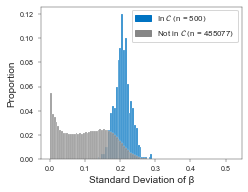

In [5]:
fig, ax = plt.subplots(figsize=figsize * sf)

CpG_stdev_means = beta_values['Lund'].std(axis=1)
plot_data = pd.DataFrame({'CpG Stdev Means':CpG_stdev_means, 'Balanced Set':CpG_stdev_means.index.isin(balanced_CpGs)})

n_balanced = balanced_CpGs.shape[0]
n_not_balanced = CpG_stdev_means.shape[0] - n_balanced

label_balanced = 'In $\mathcal{C}$' + f' (n = {n_balanced})'
label_not_balanced = 'Not in $\mathcal{C}$' + f' (n = {n_not_balanced})'
plot_data['Balanced Set'] = plot_data['Balanced Set'].map({True:label_balanced, False:label_not_balanced})
plot_data = plot_data.rename(columns={'Balanced Set':'Type'})

color_dict = {label_balanced:consts['palette_jco'][0],
              label_not_balanced:consts['palette_jco'][2]}

sns.histplot(ax=ax, data=plot_data, x='CpG Stdev Means', hue='Type', stat='proportion', common_norm=False, bins=100,
             palette=color_dict, legend=False, alpha=opacity)

ax.set_xlabel('Standard Deviation of β', fontsize=labelfontsize * sf)
ax.set_ylabel(ax.get_ylabel(), fontsize=labelfontsize * sf)
ax.tick_params(axis='both', labelsize=ticksfontsize * sf, width=sf, length=8 * sf)

patches = [mpatches.Patch(color=color_dict[group], label=group) for group in color_dict.keys()]
plots_x, plots_y = ax.get_position().get_points()[1]
fig.legend(handles=patches,
           loc='upper right',
           bbox_to_anchor=(plots_x, plots_y + .005),
           fontsize=0.8*labelfontsize * sf
          )


fig.savefig(os.path.join(figure_outdir, 'Lund_Validate.pdf'), format='pdf', pad_inches=0.1)

print(f'n = {len(useSamples)}')
vals_balanced = plot_data.loc[plot_data['Type'] == label_balanced, 'CpG Stdev Means']
vals_not_balanced = plot_data.loc[plot_data['Type'] == label_not_balanced, 'CpG Stdev Means']
pvalue = epi_util.wilcoxonRankSums(vals_balanced, vals_not_balanced).pvalue

print(f'Clock sites median: {vals_balanced.median():.3f}')
print(f'Non-clock sites median: {vals_not_balanced.median():.3f}')
print(f'Wilcoxon rank-sum test: P = {pvalue:.0e}')

## Luo

In [6]:
Luo_clinical_dir = os.path.join(consts['official_indir'], 'Luo')

beta_values['Luo'] = pd.read_table(os.path.join(Luo_clinical_dir, 'beta_values.txt'), index_col=0)
sample_map_Luo = pd.read_csv(os.path.join(Luo_clinical_dir, 'sample_map_cleaned.txt'), sep='\t')

In [7]:
using_patients = ['B4', 'B5', 'B6', 'B7', 'B8']
using_GSMs = sample_map_Luo.loc[sample_map_Luo['Patient'].isin(using_patients), 'GSM'].to_list()
patient_GSM_lists = sample_map_Luo.groupby('Patient')['GSM'].agg(list)

CpG_stdev_list = []

for patient in using_patients:
    beta_values_patient = beta_values['Luo'][patient_GSM_lists.loc[patient]]
    CpG_stdev_list.append(beta_values_patient.std(axis=1).rename(patient))
    
CpG_stdevs = pd.concat(CpG_stdev_list, axis=1)
CpG_stdev_means = CpG_stdevs.mean(axis=1)

Clock sites median: 0.070
Non-clock sites median: 0.026
Wilcoxon rank-sum test: p = 6e-179


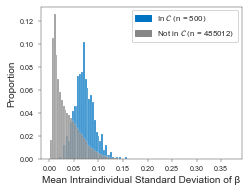

In [8]:
fig, ax = plt.subplots(1, 1, figsize=figsize * sf)

plot_data = pd.DataFrame({'CpG Stdev Means':CpG_stdev_means, 'Balanced Set':CpG_stdev_means.index.isin(balanced_CpGs)})

n_balanced = balanced_CpGs.shape[0]
n_not_balanced = CpG_stdev_means.shape[0] - n_balanced

label_balanced = 'In $\mathcal{C}$' + f' (n = {n_balanced})'
label_not_balanced = 'Not in $\mathcal{C}$' + f' (n = {n_not_balanced})'
plot_data['Balanced Set'] = plot_data['Balanced Set'].map({True:label_balanced, False:label_not_balanced})
plot_data = plot_data.rename(columns={'Balanced Set':'Type'})

color_dict = {label_balanced:consts['palette_jco'][0],
              label_not_balanced:consts['palette_jco'][2]}

sns.histplot(ax=ax, data=plot_data, x='CpG Stdev Means', hue='Type', stat='proportion', common_norm=False, bins=100, palette=color_dict,
                   legend=False, alpha=opacity)

ax.set_xlabel('Mean Intraindividual Standard Deviation of β', fontsize=labelfontsize * sf)
ax.set_ylabel(ax.get_ylabel(), fontsize=labelfontsize * sf)
ax.tick_params(axis='both', labelsize=ticksfontsize * sf, width=sf, length=8 * sf)

patches = [mpatches.Patch(color=color_dict[group], label=group) for group in color_dict.keys()]
plots_x, plots_y = ax.get_position().get_points()[1]
fig.legend(handles=patches,
           loc='upper right',
           bbox_to_anchor=(plots_x, plots_y + .005),
           fontsize=0.8*labelfontsize * sf
          )

fig.savefig(os.path.join(figure_outdir, 'Luo_Validate.pdf'), format='pdf', pad_inches=0.1)

vals_balanced = plot_data.loc[plot_data['Type'] == label_balanced, 'CpG Stdev Means']
vals_not_balanced = plot_data.loc[plot_data['Type'] == label_not_balanced, 'CpG Stdev Means']
pvalue = epi_util.wilcoxonRankSums(vals_balanced, vals_not_balanced).pvalue

print(f'Clock sites median: {vals_balanced.median():.3f}')
print(f'Non-clock sites median: {vals_not_balanced.median():.3f}')
print(f'Wilcoxon rank-sum test: P = {pvalue:.0e}')